In [ ]:
%%html
<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at 'In [17]'.</span>

An Exception was encountered at 'In [17]'.

In [1]:
# from basepair.config import get_data_dir
# ddir = get_data_dir()
# modisco_subdir = "modisco/all/deeplift/profile,counts/"
# model_dir = f"{ddir}/processed/chipnexus/exp/models/oct-sox-nanog-klf/models/n_dil_layers=9/"
# modisco_dir = os.path.join(model_dir, modisco_subdir)
# output_dir = modisco_dir

In [2]:
# Parameters
modisco_dir = "Klf4"
output_dir = "Klf4"


## Cluster the motifs by their sequence similarity

### Requires

- `{modisco_dir}/modisco.h5`
- `{output_dir}/pattern_table.csv`
- `{output_dir}/footprints.pkl`

### Produces

- `{output_dir}/patterns.pkl`
- `{output_dir}/pattern_table.html`
- `{output_dir}/pattern_table.csv`
- `{output_dir}/motif_clustering/patterns_short.html`
- `{output_dir}/motif_clustering/patterns_short.csv`
- `{output_dir}/motif_clustering/patterns_long.html`
- `{output_dir}/motif_clustering/patterns_long.csv`

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from uuid import uuid4
from basepair.math import mean
from basepair.stats import perc
from kipoi.utils import unique_list

from IPython.display import display, HTML
from basepair.plot.vdom import df2html, df2html_old, render_datatable, vdom_footprint

from basepair.modisco.core import patterns_to_df
from basepair.modisco.utils import longer_pattern, shorten_pattern, extract_name_short
from basepair.imports import *

modisco_dir = Path(modisco_dir)
output_dir = Path(output_dir)

Using TensorFlow backend.


In [4]:
mr = ModiscoResult(modisco_dir / "modisco.h5")
mr.open()
patterns = [mr.get_pattern(p) for p in mr.patterns()]

# patterns = [mr.get_pattern(p) for p in mr.patterns()]
pattern_table = pd.read_csv(output_dir / "pattern_table.csv")

tasks = unique_list([x.split("/")[0] for x in mr.tasks()])

footprints = read_pkl(output_dir / 'footprints.pkl')

# Add profile to patterns
patterns = [p.add_profile(footprints[p.name]) for p in patterns]

# Add features
patterns = [p.add_attr('features', OrderedDict(pattern_table[pattern_table.pattern == shorten_pattern(p.name)].iloc[0])) 
            for p in patterns]

# check that the pattern names match
assert patterns[2].attrs['features']['pattern'] == shorten_pattern(patterns[2].name)

---------------

### 1. split into two groups: {TE, non-TE} 

In [5]:
p = patterns[0]

In [6]:
df = patterns_to_df(patterns, properties=['short_name', 'seq_info_content'])

TF-MoDISco is using the TensorFlow backend.


In [7]:
df.head(2)

short_name  seq_info_content
0      m0_p0           14.1129
1      m0_p1           17.2202

In [8]:
# Global constant
TE_cutoff = 34

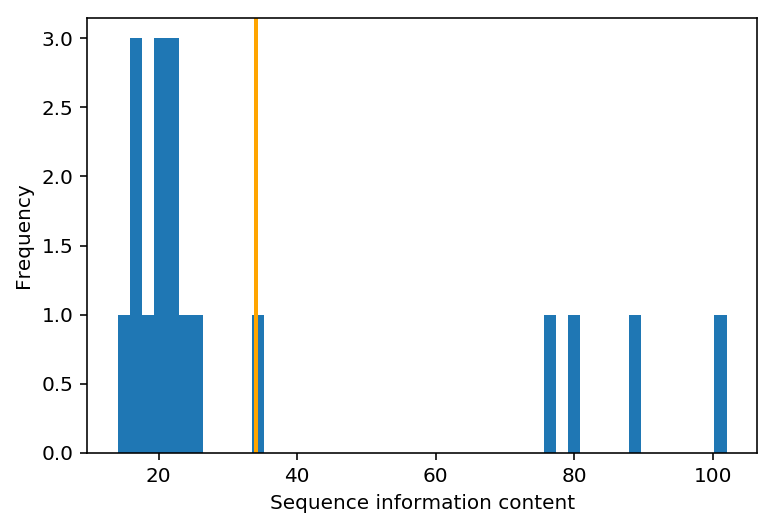

In [9]:
df.seq_info_content.plot.hist(bins=50)
plt.xlabel("Sequence information content");
plt.axvline(TE_cutoff, color='orange', linewidth=2);

In [10]:
def get_pattern_group(p):
    if p.seq_info_content > TE_cutoff:
        return "short"
    else:
        return "long"
patterns = [x.add_attr("pattern_group", get_pattern_group(x)) 
            for x in patterns]

In [11]:
patterns_te = [p for p in patterns if p.seq_info_content > TE_cutoff]
patterns_nte = [p for p in patterns if p.seq_info_content <= TE_cutoff]
assert len(patterns_te) + len(patterns_nte) == len(patterns)

### Pattern len distribution

In [12]:
ns = pattern_table['n seqlets']

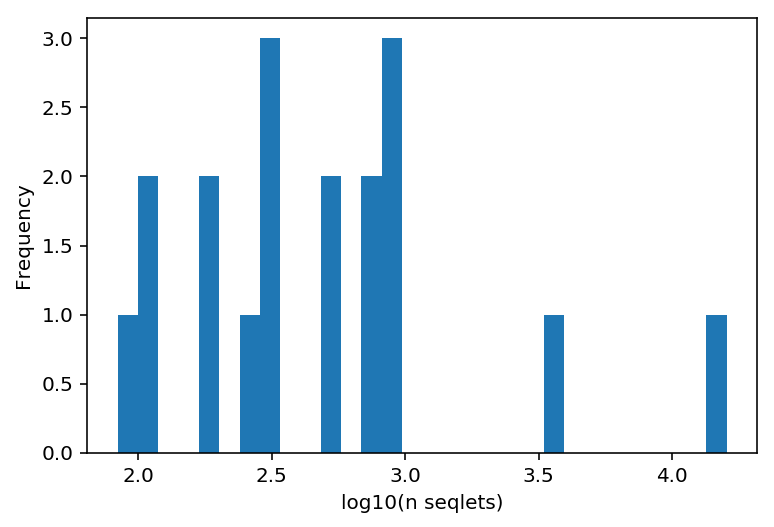

In [13]:
np.log10(ns).plot.hist(30)
plt.xlabel("log10(n seqlets)");

In [14]:
ns.quantile(0.1)

117.4

In [15]:
print("# long motifs: ", len(patterns_te))
print("# short motifs:", len(patterns_nte))

# long motifs:  5
# short motifs: 13


## 2. cluster by seq-similarty, freeze groups

In [16]:
from basepair.exp.chipnexus.motif_clustering import similarity_matrix

In [17]:
sim_nte_seq = similarity_matrix(patterns_nte, track='seq_ic')
sim_te_seq = similarity_matrix(patterns_te, track='seq_ic')
sim_all_seq = similarity_matrix(patterns, track='seq_ic')

  0%|          | 0/13 [00:00<?, ?it/s]

AssertionError: 

#### Short

In [ ]:
iu1 = np.triu_indices(len(sim_nte_seq), 1)
plt.hist(sim_nte_seq[iu1], bins=100);
plt.title("Similarity (seq_ic)")
plt.xlabel("Similarity between two motifs (short)");

#### Long

In [ ]:
iu2 = np.triu_indices(len(sim_te_seq), 1)
plt.hist(sim_te_seq[iu2], bins=100);
plt.title("Similarity (seq_ic)")
plt.xlabel("Similarity between two motifs (short)");

#### All

In [ ]:
iu_all = np.triu_indices(len(sim_all_seq), 1)
plt.hist(sim_all_seq[iu2], bins=100);
plt.title("Similarity (seq_ic)")
plt.xlabel("Similarity between two motifs (all)");

In [ ]:
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, cut_tree, leaves_list
from basepair.modisco.motif_clustering import to_colors

## Cluster the motifs

### Short motifs

In [ ]:
# Seq IC-based clustering
iu_nte = np.triu_indices(len(sim_nte_seq), 1)
lm_nte_seq = linkage(1-sim_nte_seq[iu_nte], 'ward', optimal_ordering=True)
clusters_nte_seq = cut_tree(lm_nte_seq, n_clusters=9)[:,0]
cm_nte_seq = sns.clustermap(pd.DataFrame(sim_nte_seq),
                            row_linkage=lm_nte_seq,
                            col_linkage=lm_nte_seq,
                            col_colors=to_colors(pd.DataFrame(dict(cluster=pd.Categorical(clusters_nte_seq)))),
                            cmap='Blues'
                           ).fig.suptitle('Seq-ic sim');

### Long motifs

In [ ]:
iu_te = np.triu_indices(len(sim_te_seq), 1)
lm_te_seq = linkage(1-sim_te_seq[iu_te], 'ward', optimal_ordering=True)
clusters_te_seq = cut_tree(lm_te_seq, n_clusters=9)[:,0]
cm_te = sns.clustermap(sim_te_seq,
                        row_linkage=lm_te_seq,
                        col_linkage=lm_te_seq,
                        cmap='Blues'
                       ).fig.suptitle('Seq IC sim');

### All motifs

In [ ]:
iu_all = np.triu_indices(len(sim_all_seq), 1)
lm_all_seq = linkage(1-sim_all_seq[iu_all], 'ward', optimal_ordering=True)
clusters_all_seq = cut_tree(lm_all_seq, n_clusters=9)[:,0]
cm_all = sns.clustermap(sim_all_seq,
                        row_linkage=lm_all_seq,
                        col_linkage=lm_all_seq,
                        cmap='Blues'
                       ).fig.suptitle('Seq IC sim');

### 3. Visualize the clusters

In [ ]:
from basepair.modisco.motif_clustering import create_pattern_table, align_clustered_patterns

In [ ]:
cluster_order = np.argsort(leaves_list(lm_nte_seq))
cluster = clusters_nte_seq

patterns_nte_clustered = align_clustered_patterns(patterns_nte, cluster_order, cluster, 
                                                  align_track='seq_ic',
                                                  # don't shit the major patterns 
                                                  # by more than 15 when aligning
                                                  max_shift=15)
# add the major motif group
patterns_nte_clustered = [x.add_attr("pattern_group", 'nte') for x in patterns_nte_clustered]

In [ ]:
cluster_order = np.argsort(leaves_list(lm_te_seq))
cluster = clusters_te_seq

patterns_te_clustered = align_clustered_patterns(patterns_te, cluster_order, cluster, 
                                                 align_track='seq_ic',
                                                 # don't shit the major patterns 
                                                 # by more than 15 when aligning                                             
                                                 max_shift=15)
patterns_te_clustered = [x.add_attr("pattern_group", 'te') for x in patterns_te_clustered]

In [ ]:
cluster_order = np.argsort(leaves_list(lm_all_seq))
cluster = clusters_all_seq

patterns_all_clustered = align_clustered_patterns(patterns, cluster_order, cluster, 
                                                 align_track='seq_ic',
                                                 # don't shit the major patterns 
                                                 # by more than 15 when aligning                                             
                                                 max_shift=15)

In [ ]:
# write_pkl(patterns_nte_clustered + patterns_te_clustered, output_dir / 'patterns.pkl')

In [ ]:
write_pkl(patterns_all_clustered, output_dir / 'patterns.pkl')

## Write a simple table

In [ ]:
pattern_table_nte_seq = create_pattern_table(patterns_nte_clustered,
                                             logo_len=50, 
                                             seqlogo_kwargs=dict(width=420),
                                             n_jobs=20,
                                             footprint_width=120,
                                             footprint_kwargs=dict(figsize=(3,1.5)))

In [ ]:
pattern_table_te_seq = create_pattern_table(patterns_te_clustered,
                                            logo_len=70, 
                                            seqlogo_kwargs=dict(width=420),
                                            n_jobs=20,
                                            footprint_width=120,
                                            footprint_kwargs=dict(figsize=(3,1.5)))

In [ ]:
pattern_table_all = create_pattern_table(patterns_all_clustered,
                                         logo_len=70, 
                                         seqlogo_kwargs=dict(width=420),
                                         n_jobs=20,
                                         footprint_width=120,
                                         footprint_kwargs=dict(figsize=(3,1.5)))

In [ ]:
def get_first_columns(df, cols):
    remaining_columns = [c for c in df.columns if c not in cols]
    return df[cols + remaining_columns]

In [ ]:
background_motifs = ['Essrb', 'Klf4', 'Nanog','Oct4','Oct4-Sox2', 'Sox2']

first_columns = ['pattern', 'cluster', 'n seqlets', 'logo_imp', 'logo_seq'] + [task+'/f' for task in tasks] + [t + '/d_p' for t in tasks] # + [m+'/odds' for m in background_motifs]

In [ ]:
(output_dir / 'motif_clustering').mkdir(exist_ok=True)

In [ ]:
from basepair.modisco.table import write_modisco_table

In [ ]:
remove = [task + '/f' for task in tasks] + ['logo_imp', 'logo_seq']

In [ ]:
pattern_table_nte_seq['i'] = np.arange(len(pattern_table_nte_seq), dtype=int)
pattern_table_nte_seq = get_first_columns(pattern_table_nte_seq, ['i'] + first_columns)
write_modisco_table(pattern_table_nte_seq, output_dir / 'motif_clustering', report_url='../results.html', prefix='patterns_short', exclude_when_writing=remove)

In [ ]:
pattern_table_te_seq['i'] = np.arange(len(pattern_table_te_seq), dtype=int)
pattern_table_te_seq = get_first_columns(pattern_table_te_seq, ['i'] + first_columns)
write_modisco_table(pattern_table_te_seq, output_dir / 'motif_clustering', report_url='../results.html', prefix='patterns_long', exclude_when_writing=remove)

In [ ]:
pattern_table_all['i'] = np.arange(len(pattern_table_all), dtype=int)
pattern_table_all = get_first_columns(pattern_table_all, ['i'] + first_columns)
write_modisco_table(pattern_table_all, output_dir, report_url='results.html', prefix='pattern_table', exclude_when_writing=remove)